In [77]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
import seaborn as sns
import codebase

In [78]:
from codebase import volume_pipeline

In [79]:
res_name = 'Powell'

# Load data

In [80]:
res_name_dict = {'Powell':'glen canyon',
                 'Mead': 'hoover',
                 'Mohave': 'davis bor',
                 'Havasu': 'parker'}

In [81]:
res_ref = codebase.load_data.load_formatted_usbr_data(res_name,monthly=True)
print(res_ref.columns)

Index(['Lake/Reservoir Area [acres]', 'Lake/Reservoir Bank Storage [af]',
       'Lake/Reservoir Change In Storage [af]',
       'Lake/Reservoir Elevation [ft]', 'Lake/Reservoir Evaporation [af]',
       'Lake/Reservoir Inflow - Unregulated [cfs]',
       'Lake/Reservoir Inflow Volume - Unregulated [af]',
       'Lake/Reservoir Inflow [af]', 'Lake/Reservoir Inflow [cfs]',
       'Lake/Reservoir Release - Bypass [af]',
       'Lake/Reservoir Release - Bypass [cfs]',
       'Lake/Reservoir Release - Powerplant [af]',
       'Lake/Reservoir Release - Powerplant [cfs]',
       'Lake/Reservoir Release - Spillway [cfs]',
       'Lake/Reservoir Release - Total [af]',
       'Lake/Reservoir Release - Total [cfs]', 'Lake/Reservoir Storage [af]'],
      dtype='object', name='Variable')


<Axes: xlabel='Datetime (UTC)'>

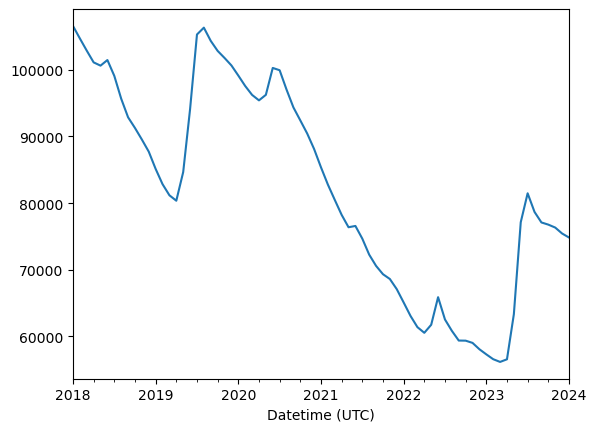

In [82]:
res_ref['Lake/Reservoir Area [acres]'].plot()

In [83]:
res_shp = codebase.load_data.load_GRanD()

In [84]:
# Volume pipeline with crs projection
dem_DA , fw_DA = volume_pipeline.create_aligned_DEM_CYGNSS_subsets(res_name_dict[res_name],res_shp,epsg_code=54017)
fw_diff_DA = volume_pipeline.difference_over_time(fw_DA)
change_cond_DA = volume_pipeline.decide_expansion_or_shrinkage_vectorize(fw_diff_DA, input_core_dims = ['y','x'])
test_vol = volume_pipeline.calculate_rough_volume(dem_DA,fw_DA,fw_diff_DA,change_cond_DA,area_kwargs = {'input_core_dims' : [['y','x']], "vectorize": True})

# Plotting functions

In [30]:
def combine_ref_calc_data(ref_series,calc_series):
    combo_data = pd.concat([ref_series, calc_series],axis=1)
    combo_data.columns = ['Reference','Calculated']
    return combo_data

In [31]:
def calc_min_max_from_df(df,precision=0):
    mn = np.round(df.values.min(),precision)
    mx = np.round(df.values.max(),precision)
    return mn , mx

In [32]:
def square_existing_plot(ax,mn=0,mx=1):
    ax.set_xlim([mn, mx])
    ax.set_ylim([mn, mx])
    ax.set_aspect('equal', adjustable='box')
    ax.grid()
    return ax

In [33]:
def add_best_fit_line_to_existing_plot(ax,lin_regress_vals,mn=0,mx=1):
    x = [mn, mx]
    m = lin_regress_vals['slope'].values
    b = lin_regress_vals['intercept'].values
    y = m*x+b
    ax.plot(x,y)
    return ax

In [34]:
def scatter_with_best_fit(ref_data,calc_data,plt_kwargs={},mnmx_precision=0):
    lin_regress_vals = codebase.time_series_calcs.linregress_wrap(ref_data,calc_data.to_frame())
    print(lin_regress_vals)
    
    combo_data = combine_ref_calc_data(ref_data,calc_data)
    mn , mx = calc_min_max_from_df(combo_data,precision=mnmx_precision)
    
    ax = combo_data.plot(x='Reference',y='Calculated',c=combo_data.index,kind='scatter')
    
    add_best_fit_line_to_existing_plot(ax,lin_regress_vals,mn,mx)
    
    square_existing_plot(ax,mn,mx)
    return combo_data, lin_regress_vals, ax

# Area comparison

In [35]:
res_calc_area_m2 = codebase.area_calcs.CYGNSS_001_area_calculation(fw_DA)
res_calc_area_m2 = pd.Series(data = res_calc_area_m2, index = fw_DA['time'])

In [36]:
# Convert nominal area to pd.Series input
# nominal_area_dict = {'Havasu':20400}
# nominal_area_ac = nominal_area_dict['Havasu']
# nominal_area_m2 = codebase.utils.convert_from_ac_to_m2(nominal_area_ac)
# res_ref_data = pd.Series(data = nominal_area_m2, index = res_calc_area_m2.index)
# noise = np.random.normal(0,0.1,[len(res_ref_data),])
# res_ref_area = res_ref_data + noise
# print(nominal_area_m2)

# For Lake Powell
res_ref_area_ac = res_ref['Lake/Reservoir Area [acres]']
res_ref_area = codebase.utils.convert_from_ac_to_m2(res_ref_area_ac)

In [37]:
area_calc_match , area_ref_match = codebase.time_series_calcs.intersecting_timeframes(res_calc_area_m2,res_ref_area,buffer=0)

      slope        intercept   r_value   p_value   std_err
0  0.449281  85629214.201848  0.543592  0.000012  0.093542


(70000000.0, 210000000.0)

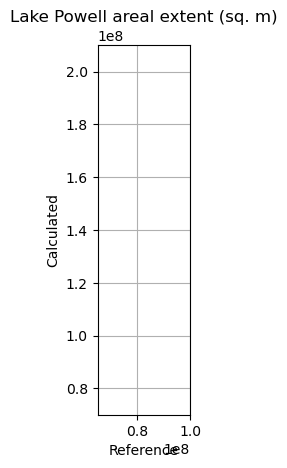

In [38]:
area_outputs = scatter_with_best_fit(ref_data=area_ref_match , calc_data = area_calc_match, mnmx_precision=-6)
area_outputs[2].set_xlabel('Reference')
area_outputs[2].set_ylabel('Calculated')
area_outputs[2].set_title('Lake ' + res_name +' areal extent (sq. m)');

# subset
area_outputs[2].set_xlim([0.65e8,1e8])
area_outputs[2].set_ylim([0.70e8,2.1e8])

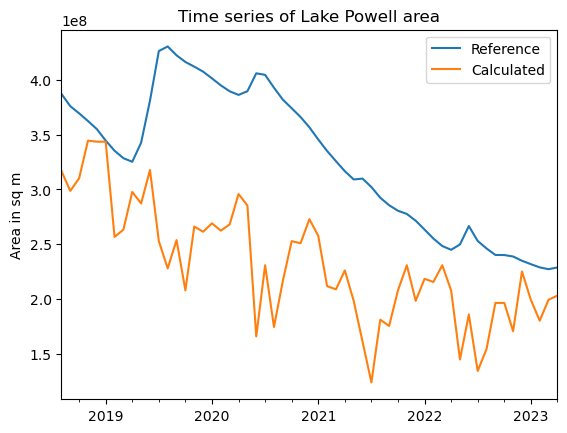

In [39]:
area_outputs[0].plot()
plt.title('Time series of Lake ' + res_name +' area')
plt.ylabel('Area in sq m');

# Elevation comparison

In [40]:
from scipy.stats import norm
norm_fits = volume_pipeline.loop_through_time_series_to_get_fit_params(dem_DA, fw_DA, 1, norm)
norm_elev_m = [val[0] for val in norm_fits]
norm_elev_series_m = pd.Series(index=fw_DA['time'], data = norm_elev_m)

In [41]:
res_ref_elev_ft = res_ref['Lake/Reservoir Elevation [ft]']
res_ref_elev_m = codebase.utils.convert_from_ft_to_m(res_ref_elev_ft)

elev_calc_norm_match ,elev_ref_match = codebase.time_series_calcs.intersecting_timeframes(norm_elev_series_m,res_ref_elev_m,buffer=0)

      slope    intercept   r_value   p_value   std_err
0  0.108893  1030.071469  0.196658  0.142593  0.073205


(1135.0, 1165.0)

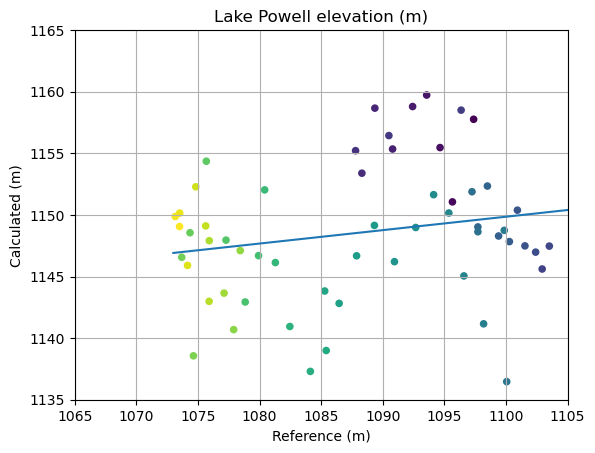

In [42]:
elev_outputs = scatter_with_best_fit(calc_data=elev_calc_norm_match , ref_data = elev_ref_match)
elev_outputs[2].set_xlabel('Reference (m)')
elev_outputs[2].set_ylabel('Calculated (m)')
elev_outputs[2].set_title('Lake '+res_name + ' elevation (m)');

subset_dict = {'Powell':([1065,1105],[1135,1165]),
               'Mead'  :([310,340]  ,[380,410]),
               'Havasu':([130,140]  ,[150,180])}

location = res_name
# subset by location
elev_outputs[2].set_xlim(subset_dict[location][0])
elev_outputs[2].set_ylim(subset_dict[location][1])


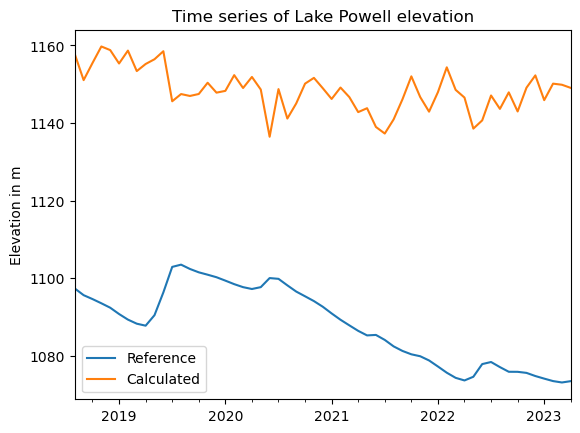

In [43]:
elev_outputs[0].plot()
plt.title('Time series of Lake ' + res_name+ ' elevation')
plt.ylabel('Elevation in m');

# Area-elevation curves

/tmp/ipykernel_18285/208779215.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_ticks.astype(int))


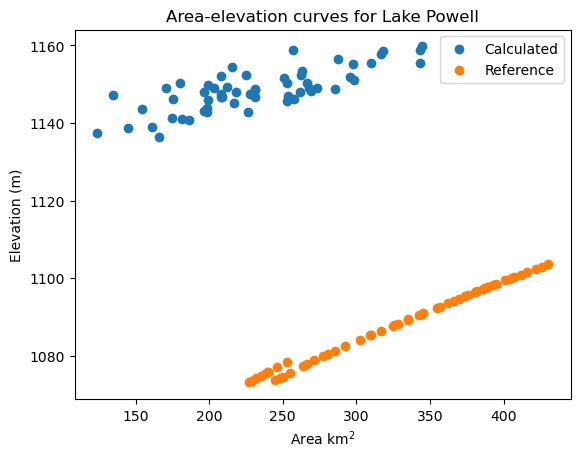

In [76]:
## Comparison of calculated and reference for Lake Powell

data_type = 'Calculated'
plt.scatter(area_outputs[0][data_type],elev_outputs[0][data_type],label=data_type)

data_type = 'Reference'
plt.scatter(area_outputs[0][data_type],elev_outputs[0][data_type],label=data_type)

ax = plt.gca()
x_tick_vals = ax.get_xticks()
new_x_ticks = x_tick_vals / (10**6)
ax.set_xticklabels(new_x_ticks.astype(int))

plt.legend()
plt.title('Area-elevation curves for Lake Powell')
plt.ylabel('Elevation (m)')
plt.xlabel('Area km$^2$')


# plt.savefig('../figures/area_elev_comp_LakePowell.png')